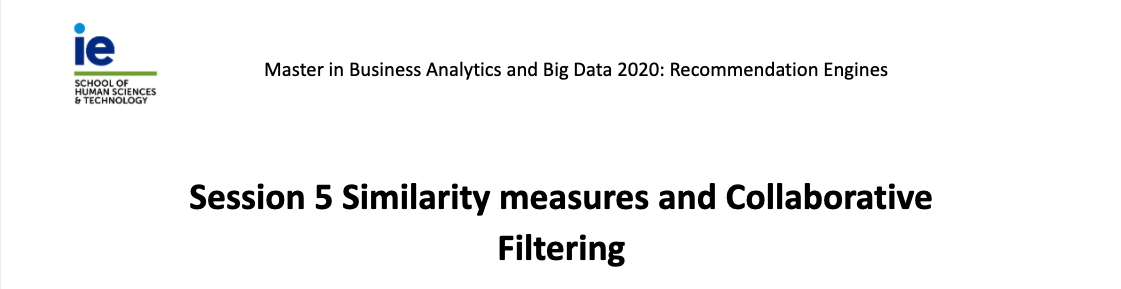

# Introduction

Please make sure that you are connected to a hosted Google Colab environment. If that's the case, at the upper right part of your screen you should see a green check mark like this one 

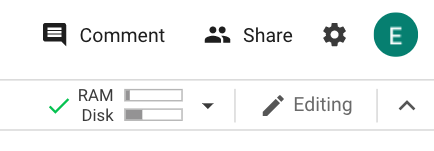

If you are not connected, please click on Connect button 

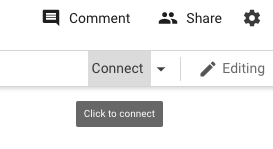

**Before continue, please expand all notebook sections, View->Expand sections**

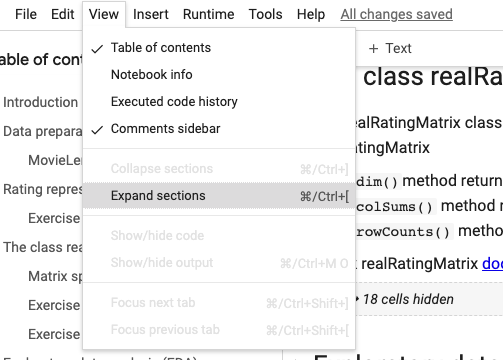



After that please, execute cells below to install required libraries, it will take a couple of minutes. 

## Environment setup

In [2]:
install.packages(c('dplyr','ggplot2','knitr','recommenderlab'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’




In [3]:
library(dplyr)
library(ggplot2)
library(knitr)
library(recommenderlab)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



#Similarities 

In our previous session we covered how to measure similarities among users or items. In this section we are going to put that in practice, using the functions provided by recommenderlab.

In [4]:
data(MovieLense)

In [5]:
## we use set.seed to get exactly the same 50 users. 
#Seed is the seed used by pseudorandom number generator, widely used to make experiment reproducible 
set.seed(1)

## let's get a sample with 10 user who have rate at least 410 movies, that will ease make comparison
my_sample <- sample(MovieLense[rowCounts(MovieLense) > 410,], 10)

In [6]:
my_sample

10 x 1664 rating matrix of class ‘realRatingMatrix’ with 5117 ratings.

In [7]:
my_sample@data[1:10, 1:10]

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                       
416 5 4 . 4 . . 4 5 5 3
276 5 4 3 4 3 . 5 4 5 .
393 3 4 3 4 3 . 4 3 4 .
13  3 3 . 5 1 . 2 4 3 .
181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
450 4 4 4 3 . . 4 . . 4
234 3 2 . 4 3 . 2 5 3 3
655 2 3 . 2 2 4 3 3 3 .
303 5 3 3 4 2 . 4 5 5 .

In [8]:
options(repr.plot.width=15, repr.plot.height=8)

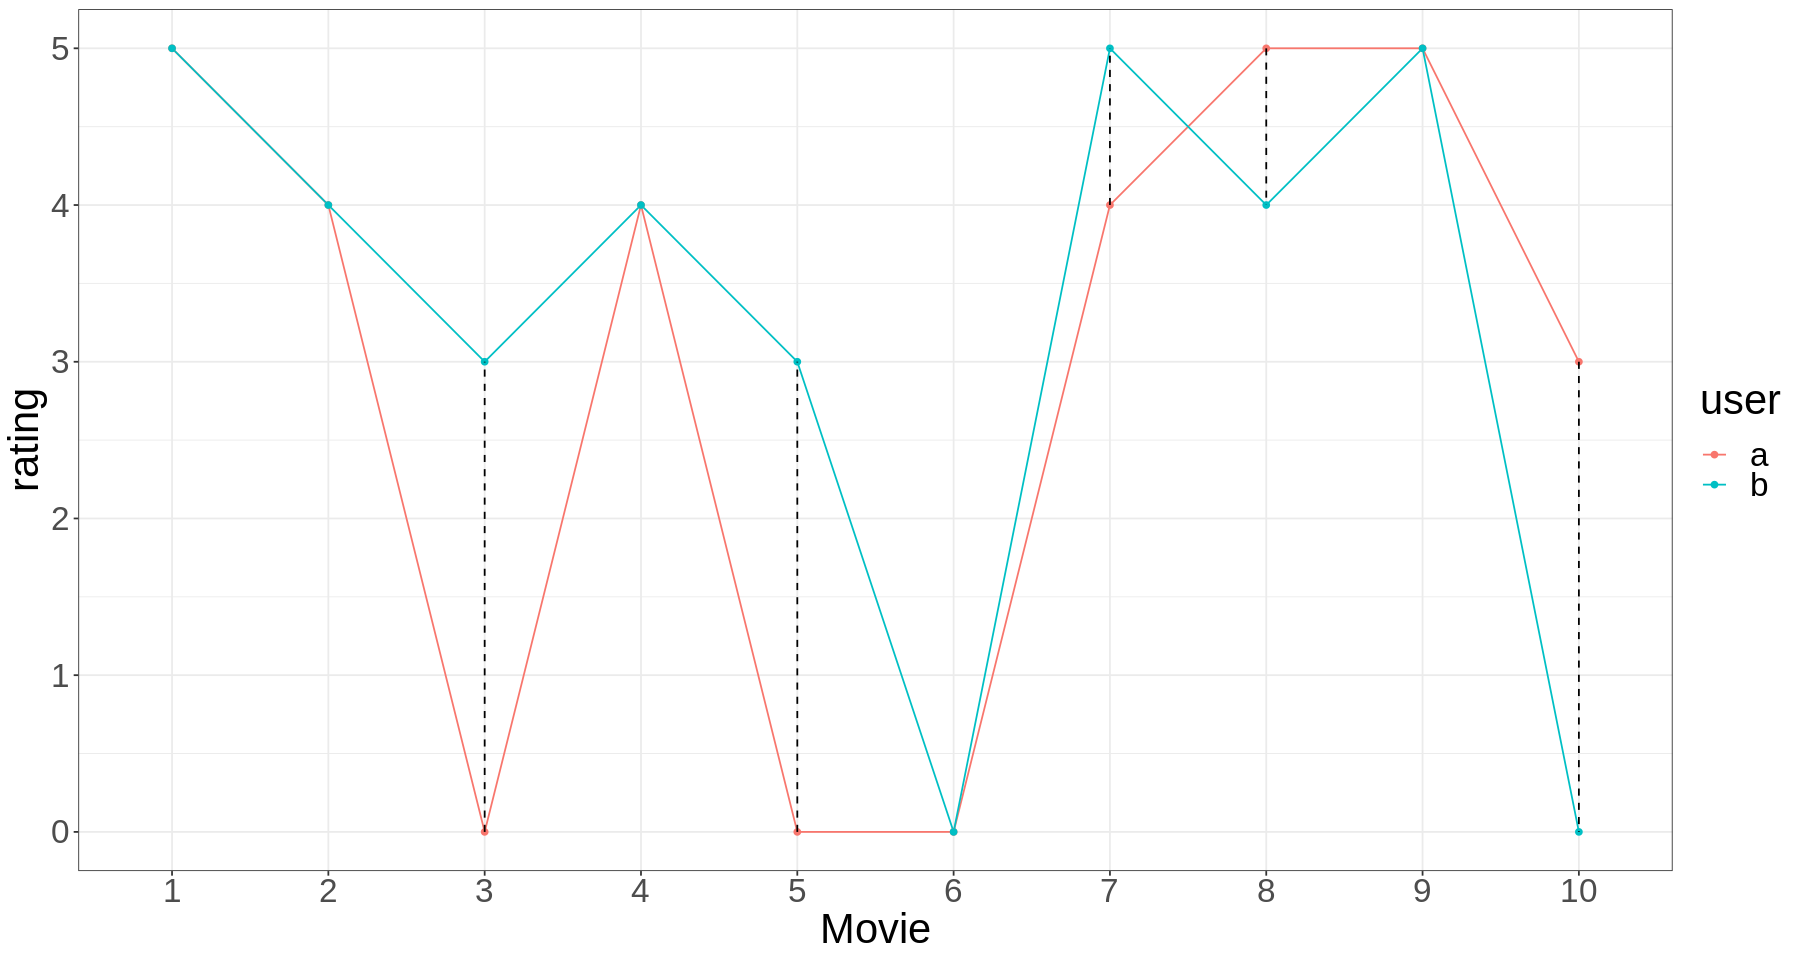

In [9]:
first_movie =1
last_movie=10
num_movies= last_movie-first_movie+1
user_a <- my_sample@data[1,first_movie:last_movie ]
user_b <- my_sample@data[2,first_movie:last_movie ]

data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a,user_b),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")  


In [10]:
normalized_sample <-normalize(my_sample[1:2,1:10])
normalized_sample@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



2 x 10 sparse Matrix of class "dgCMatrix"
                                                                         
416 0.7142857 -0.2857143  .     -0.2857143  .     . -0.2857143  0.7142857
276 0.8750000 -0.1250000 -1.125 -0.1250000 -1.125 .  0.8750000 -0.1250000
                       
416 0.7142857 -1.285714
276 0.8750000  .       

Let's plot both date normalized and denormalized

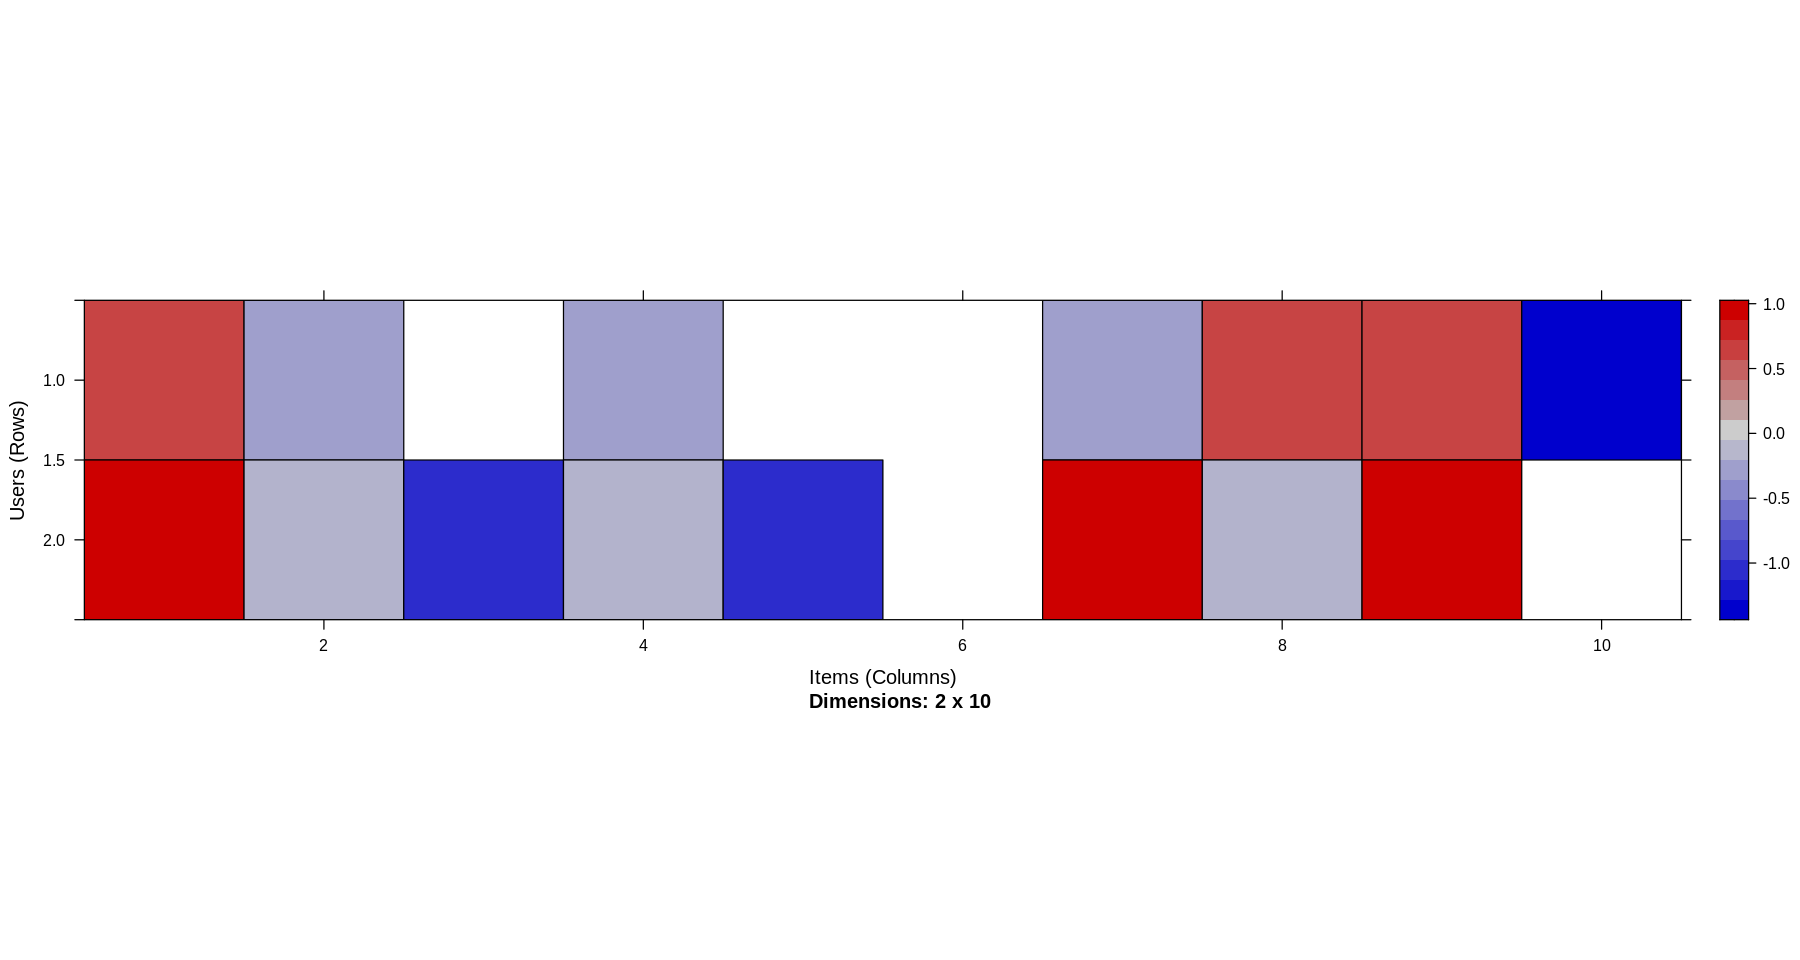

In [11]:
image(normalized_sample)

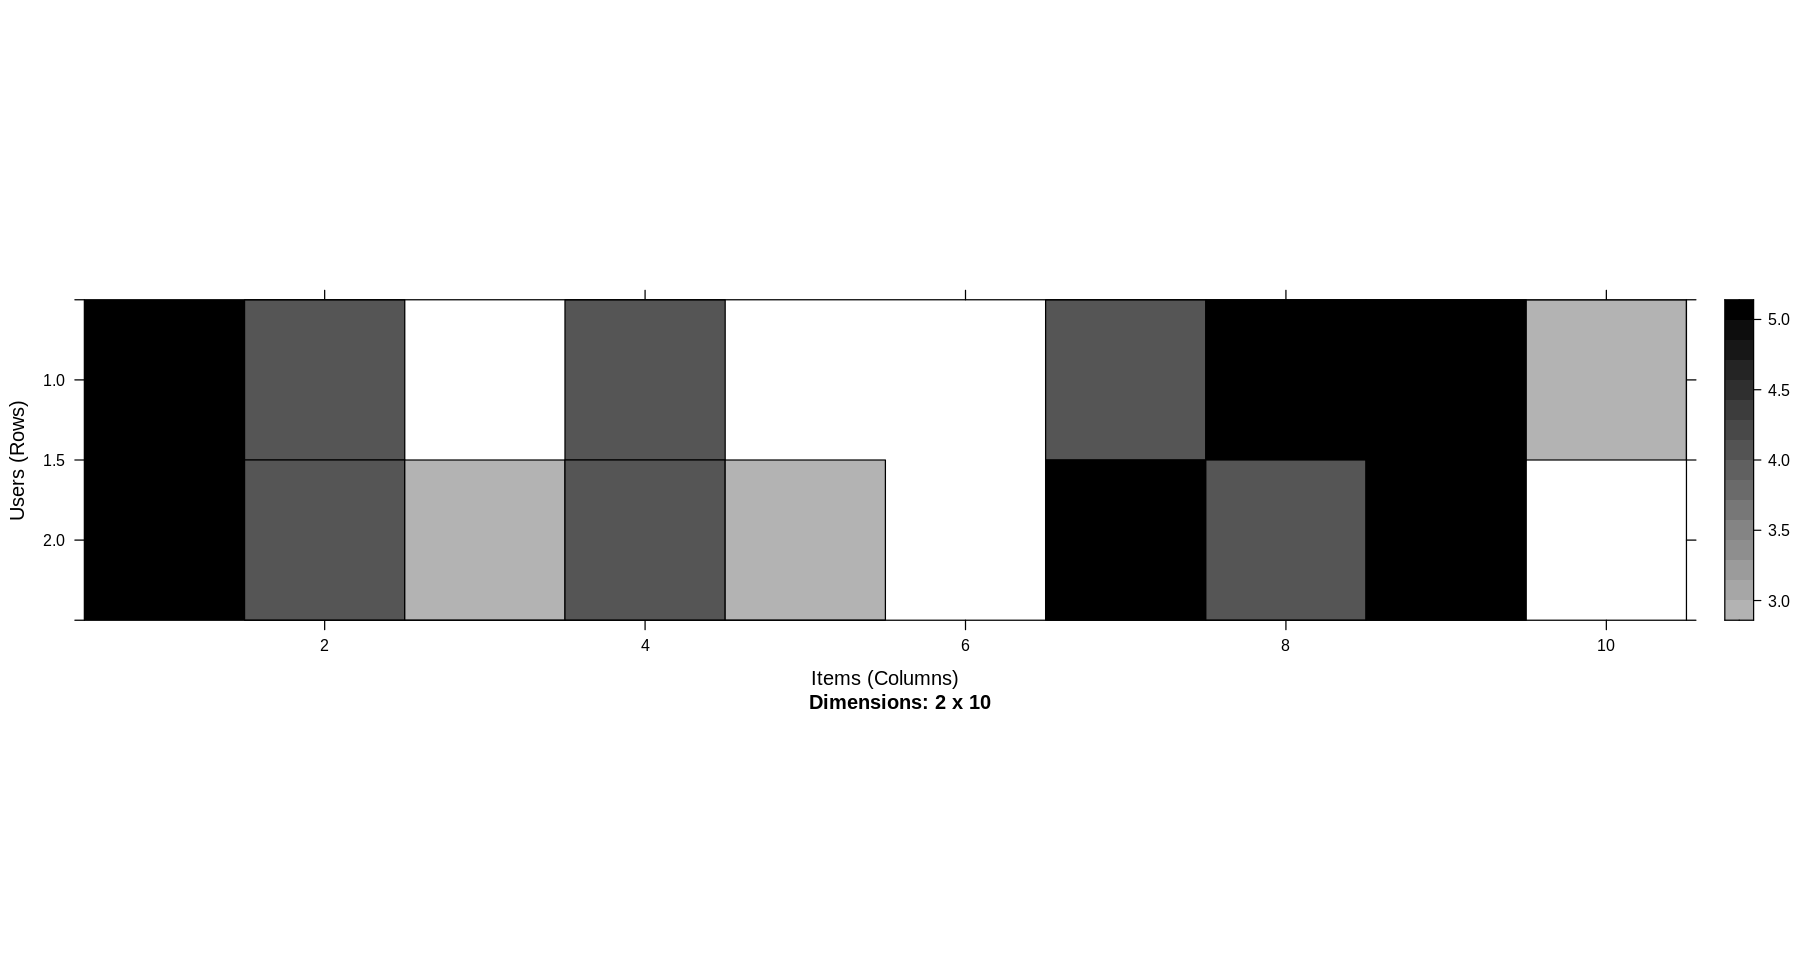

In [12]:
image(denormalize(normalized_sample))

## Exercise 1 (1 points)
Please normalize the rating of user A and B and then plot a graph like we plotted below



```
user_a <- my_sample@data[1,first_movie:last_movie ]
user_b <- my_sample@data[2,first_movie:last_movie ]

data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a,user_b),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")  
```
Instead of user_a and user_b create the variables user_a_normalized and user_b_normalized and make the required changes in code. 


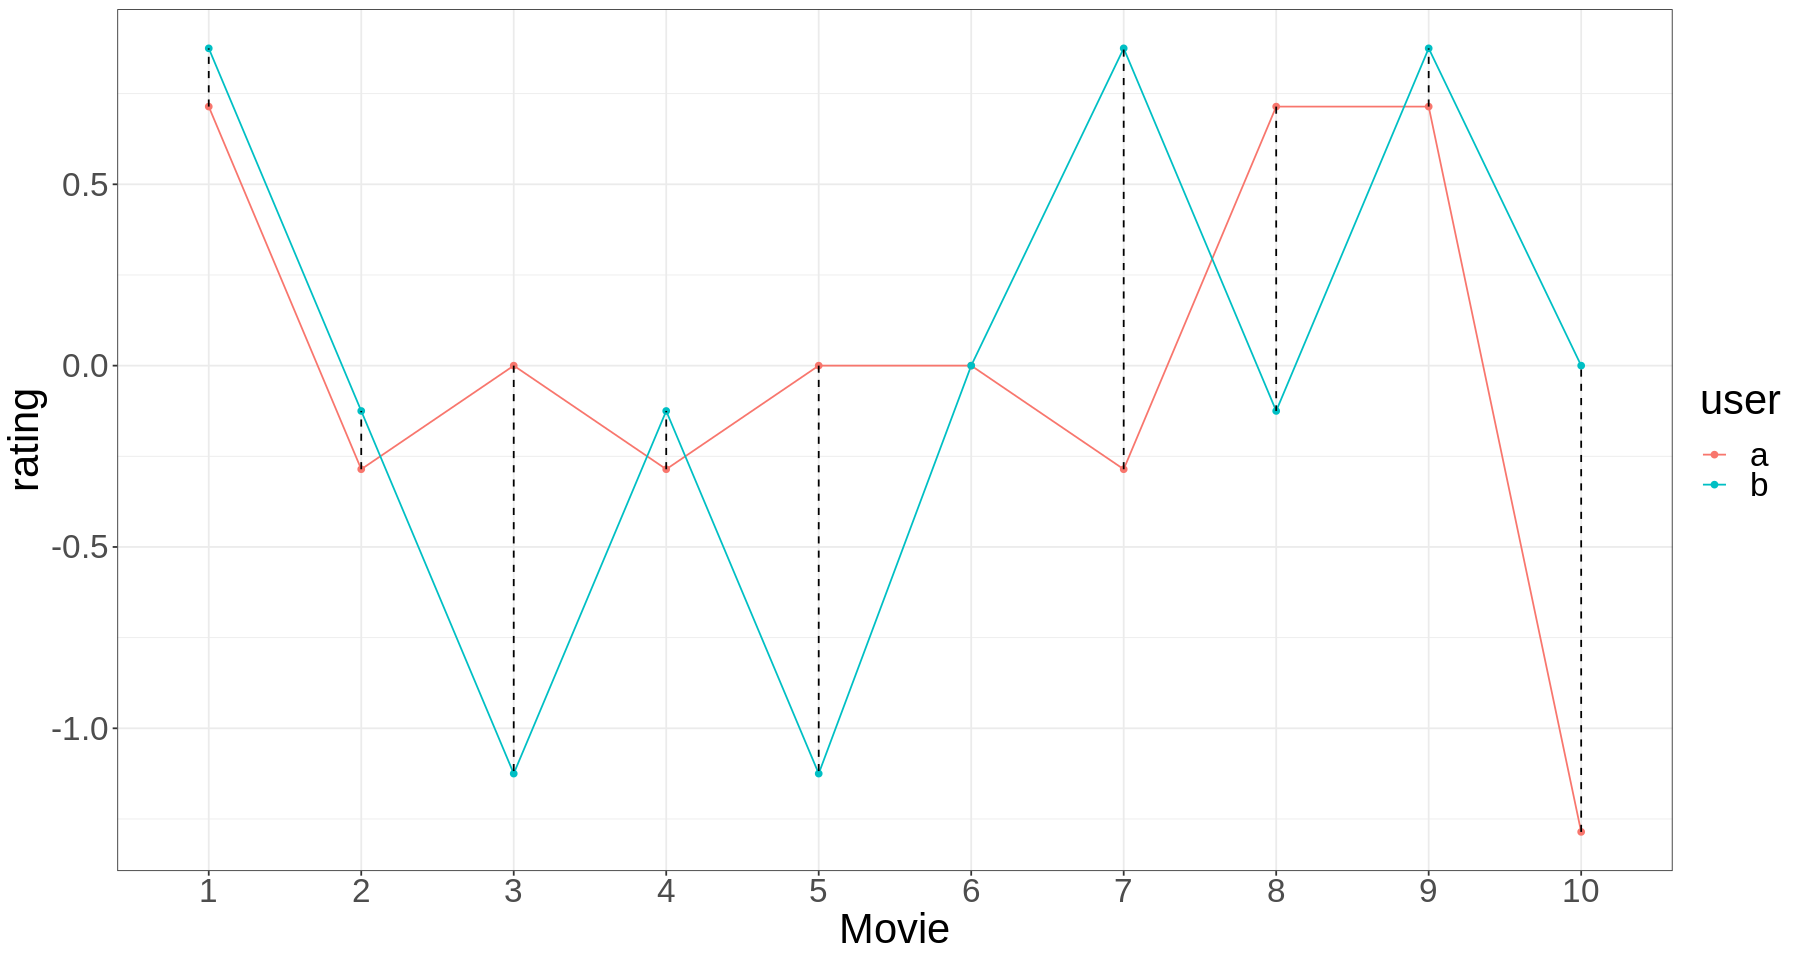

In [13]:
## INSERT YOUR CODE HERE
normalized_sample <-normalize(my_sample[1:2,1:10])

user_a_normalized <- normalized_sample@data[1,first_movie:last_movie ]
user_b_normalized <- normalized_sample@data[2,first_movie:last_movie ]

data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a_normalized,user_b_normalized),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")  

Let's compute the similarity between user_a and user_b using the adjusted cosine similarity

\begin{equation}
sim(i,j) = \dfrac{\sum\limits_{u\in U}(R_{u,i} - \overline{R_i})(R_{u,j}-\overline{R_j})}
{\sqrt{\sum\limits_{u \in U} (R_{u,i}- \overline{R_i})^2 \sum\limits_{u\in U} (R_{u,j} - \overline{R_j})^2}}
\end{equation}

In [14]:
similarity(normalize(my_sample[1:2,1:10]), method ="cosine",  which = "users", min_matching=1)

          416
276 0.4814569

In [15]:
normalize(my_sample[1:2,1:10])@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



2 x 10 sparse Matrix of class "dgCMatrix"
                                                                         
416 0.7142857 -0.2857143  .     -0.2857143  .     . -0.2857143  0.7142857
276 0.8750000 -0.1250000 -1.125 -0.1250000 -1.125 .  0.8750000 -0.1250000
                       
416 0.7142857 -1.285714
276 0.8750000  .       

Let's compute the adjusted cosine similarity manually 

In [16]:
a_norm<-c(0.7142857, -0.2857143,  -0.2857143,-0.2857143,  0.7142857, 0.7142857 ) 
b_norm<-c(0.8750000, -0.1250000, -0.1250000, 0.8750000 ,-0.1250000 ,0.8750000  ) 

In [17]:
a_norm * b_norm

[1]  0.62499999  0.03571429  0.03571429 -0.25000001 -0.08928571  0.62499999

In [18]:
sum(a_norm * b_norm) / ( sqrt(sum(a_norm*a_norm)) * sqrt(sum(b_norm*b_norm)) )

[1] 0.4814569

## Exercise 2 (0.5 points)

Please compute the cosine similarity with the ratings of user 276 and 416, who are stored in positions 1 and 2 of my_sample rating matrix, using the function **similarity**


**Answer:**

In [19]:
## INSERT YOUR CODE HERE
similarity(normalize(my_sample[1:2,]), method ="cosine",  which = "users", min_matching=1)

          416
276 0.4013546

## Exercise 3 (1.5 points)

Plesae compute the cosine similarity manually and check that the result that you obtain
 using the previous code. 

1. Create two vector with the ratings of user 276 and 416, who are stored in positions 1 and 2 of my_sample rating matrix. **Please consider only movies from 1 to 10**
2. Compute the cosine similarity using the functions sum, sqrt like we did previously 

```
sum(a_norm * b_norm) / ( sqrt(sum(a_norm*a_norm)) * sqrt(sum(b_norm*b_norm)) )
```
3. Check that obtained result is exactly the same obtained using **similiraty** function. 



**Answer:**

In [20]:
## INSERT YOUR CODE HERE
a_norm_manual <- normalize(my_sample[1,1:10])@data
b_norm_manual <- normalize(my_sample[2,1:10])@data

a_norm_manual_vector <- c()
b_norm_manual_vector <- c()

for (i in 1:length(a_norm_manual)){
  if(a_norm_manual[i]!=0 & b_norm_manual[i]!=0){
    a_norm_manual_vector <- c(a_norm_manual_vector, a_norm_manual[i]);
    b_norm_manual_vector <- c(b_norm_manual_vector, b_norm_manual[i])
  }else{
    next
  }
}

#a_norm_manual_vector * b_norm_manual_vector

sum(a_norm_manual_vector * b_norm_manual_vector) / ( sqrt(sum(a_norm_manual_vector * a_norm_manual_vector)) * sqrt(sum(b_norm_manual_vector *b_norm_manual_vector)) )

[1] 0.4814569

## Jaccard similarity

In session 2 we saw that another similarity measure, the **Jaccard similiraty**

$jaccard(A, B) = \frac{|A \bigcap B|}{ |A\bigcup B|}$
```
my_sample@data[5:6, 1:10]

181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
```




In [21]:
binary_matrix <-binarize(my_sample[5:6,1:10], minRating=1)
as(binary_matrix,"matrix")

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995)
181,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE
279,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE


In [22]:
similarity(binary_matrix, method ="jaccard",  which = "users")

      181
279 0.375

### Exercise 4 (1 points)

In previous example first we binarize the rating matrix into 1s and 0s and then we compute the jaccard similarity, can you explain how we obtain the value of 0.375 for the Jaccard similarity beteween user 279 and 181. 

- $|A \bigcap B|$
- $|A\bigcup B|$

Hint: 3/8 = 0.375

**Answer:**

If we look at the matrix above, we can see that only 3 out of the 8 film are rated by both users 279 and 181, this are:


1.   Toy Story
2.   Twelve Monkeys
3.   Richard III

out of the 8 film that were subframed. So if we divide the intersection (3)
by the union(8) we then get 0.375



## Minimum Overlap

In session 4 we saw that in order to compute similarities a minimum overlap is required, let's compute similarities using our sample.

In [23]:
my_sample[,1:10]@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                       
416 5 4 . 4 . . 4 5 5 3
276 5 4 3 4 3 . 5 4 5 .
393 3 4 3 4 3 . 4 3 4 .
13  3 3 . 5 1 . 2 4 3 .
181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
450 4 4 4 3 . . 4 . . 4
234 3 2 . 4 3 . 2 5 3 3
655 2 3 . 2 2 4 3 3 3 .
303 5 3 3 4 2 . 4 5 5 .

In [24]:
similarity_users <-similarity(normalize(my_sample[,1:10]), method ="cosine",  which = "users", min_matching=4)
similarity_users

           416        276        393         13        181        279
276 0.48145692                                                       
393 0.48145692 0.48038446                                            
13  0.13130643 0.16645008 0.23904572                                 
181 0.49522242 0.88189470 0.73979544         NA                      
279 0.45566119 0.00000000 0.70710678 0.31622777         NA           
450 0.03418928 0.12422363 0.41522740 0.92966968 0.10000000 0.00000000
234 0.35349586 0.25435880 0.45098150 0.60370911 0.69955860 0.38760127
655 0.06857255 0.24816039 0.33942212 0.00000000 0.43768811 0.63245553
303 0.90663966 0.77915234 0.11867817 0.55523433 0.71133103 0.49236596
           450        234        655
276                                 
393                                 
13                                  
181                                 
279                                 
450                                 
234 0.69979992                      
655 

## Exercise 5 (1 points)

Why similarity of user 13 and 181 is *NA* 

**Answer:**

Because we've set the threshold to 4 in `min_matching` to 4, while there are only three films that both users 13 and 181 have rated, positioned in the matrix in columns 1,7 and 9.

# Recommendation models

The recommenderlab package contains some options for the recommendation algorithm. We can display the model applicable to the realRatingMatrix objects using recommenderRegistry$get_entries:

```
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
```

The recommender_models object contains some information about the models. First, let's see which models we have:
`names(recommender_models)`



In [25]:
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
names(recommender_models)

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

In [26]:
lapply(recommender_models, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

## Item-based collaborative filtering


We will build the model using a part of the MovieLense dataset (the training set) and apply it on the other part (the test set). Since it's not a topic of this session , we will not evaluate the model, but will only recommend movies to the users in the test set.

The two sets are as follows:
- Training set: This set includes users from which the model learns.
- Test set: This set includes users to whom we recommend movies.

The algorithm automatically normalizes the data, so we can use ratings_movies that contains relevant users and movies of MovieLense. We defined ratings_movies as the subset of MovieLense users who have rated at least 50 movies and movies that have been rated at least 100 times.


In [27]:
ratings_movies <- MovieLense[rowCounts(MovieLense) >= 50,colCounts(MovieLense) >= 100]
ratings_movies

565 x 336 rating matrix of class ‘realRatingMatrix’ with 55832 ratings.

### Training and test dataset
First, we randomly define the which_train vector that is TRUE for users in the training set and FALSE for the others. We will set the probability in the training
set as 80 percent.

In [28]:
set.seed(123)
which_train <- sample(x = c(TRUE, FALSE), size = nrow(ratings_movies), replace = TRUE, prob = c(0.8, 0.2))
head(which_train,10)

[1]  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE

In [29]:
recc_data_train <- ratings_movies[which_train, ]
recc_data_test <- ratings_movies[!which_train, ]

In [30]:
recc_data_train@data[1:10,1:10]

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Get Shorty (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                      
1  5 3 3 4 1 5 2 5 5 5
2  4 . . . . . . . 4 4
3  . . . . . . . . . .
7  . . 5 5 5 5 3 5 . .
8  . . . 3 . . 3 . . .
11 . . . . 4 5 2 2 . .
12 . . 5 . . . . . . .
14 . . . 5 . 4 . 5 4 3
15 1 . . 1 . 4 . . 1 4
16 5 . 5 5 5 5 5 5 . .

The function to build models is recommender and its inputs are as follows:
- Data: This is the training set
- Method: This is the name of the technique
- Parameters: These are some optional parameters of the technique

In [31]:
recommenderRegistry$get_entry("IBCF", dataType="realRatingMatrix")

Recommender method: IBCF for realRatingMatrix
Description: Recommender based on item-based collaborative filtering.
Reference: NA
Parameters:
   k   method normalize normalize_sim_matrix alpha na_as_zero
1 30 "Cosine"  "center"                FALSE   0.5      FALSE

In [32]:
recc_model_ibcf <- Recommender(data = recc_data_train, method = "IBCF",
parameter = list(k = 30))

In [33]:
recc_model_ibcf

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 456 users.

The recc_model class is an object of the `Recommender` class containing the model

In [34]:
class(recc_model_ibcf)

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

In [35]:
model_details <- getModel(recc_model_ibcf)
model_details$description
dim(model_details$sim)

[1] "IBCF: Reduced similarity matrix"

[1] 336 336

As expected, model_details$sim is a square matrix whose size is equal to the number of items. We can explore a part of it using image.

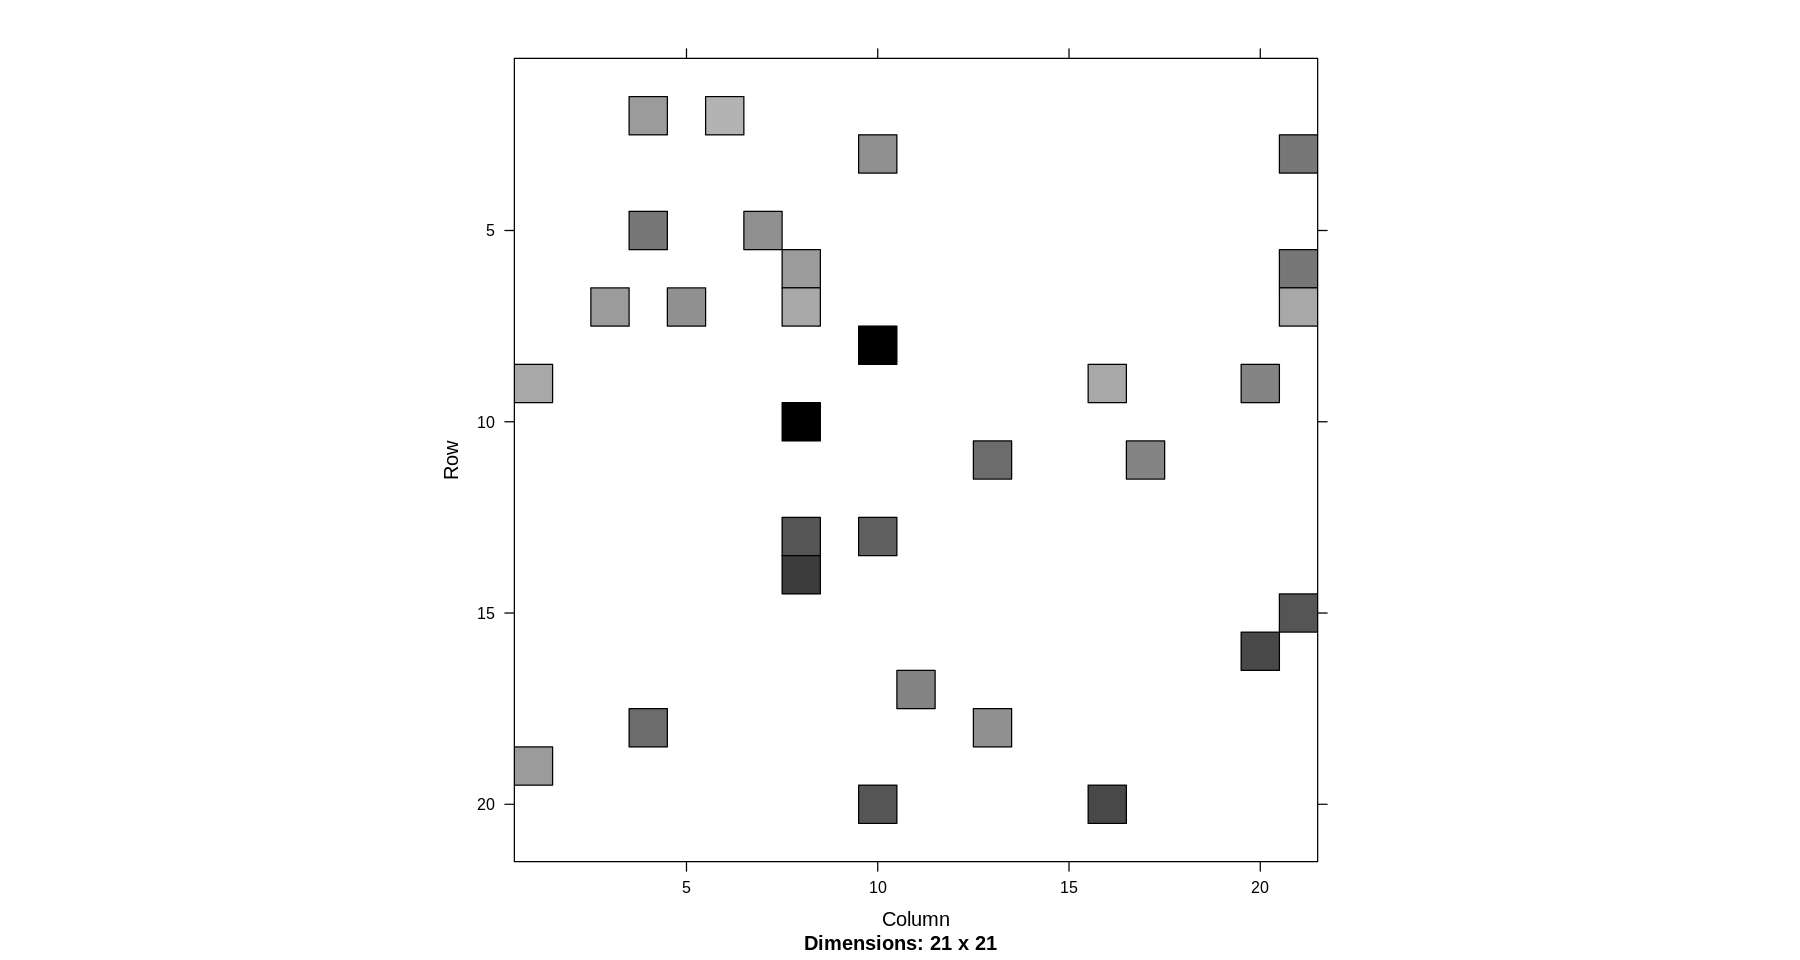

In [36]:
image (model_details$sim[10:30,10:30])

Most of the values are equal to 0. The reason is that each row contains only k elements. Let's check it:

In [37]:
row_sums <- rowSums(model_details$sim > 0)
table(row_sums)

row_sums
 30 
336 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



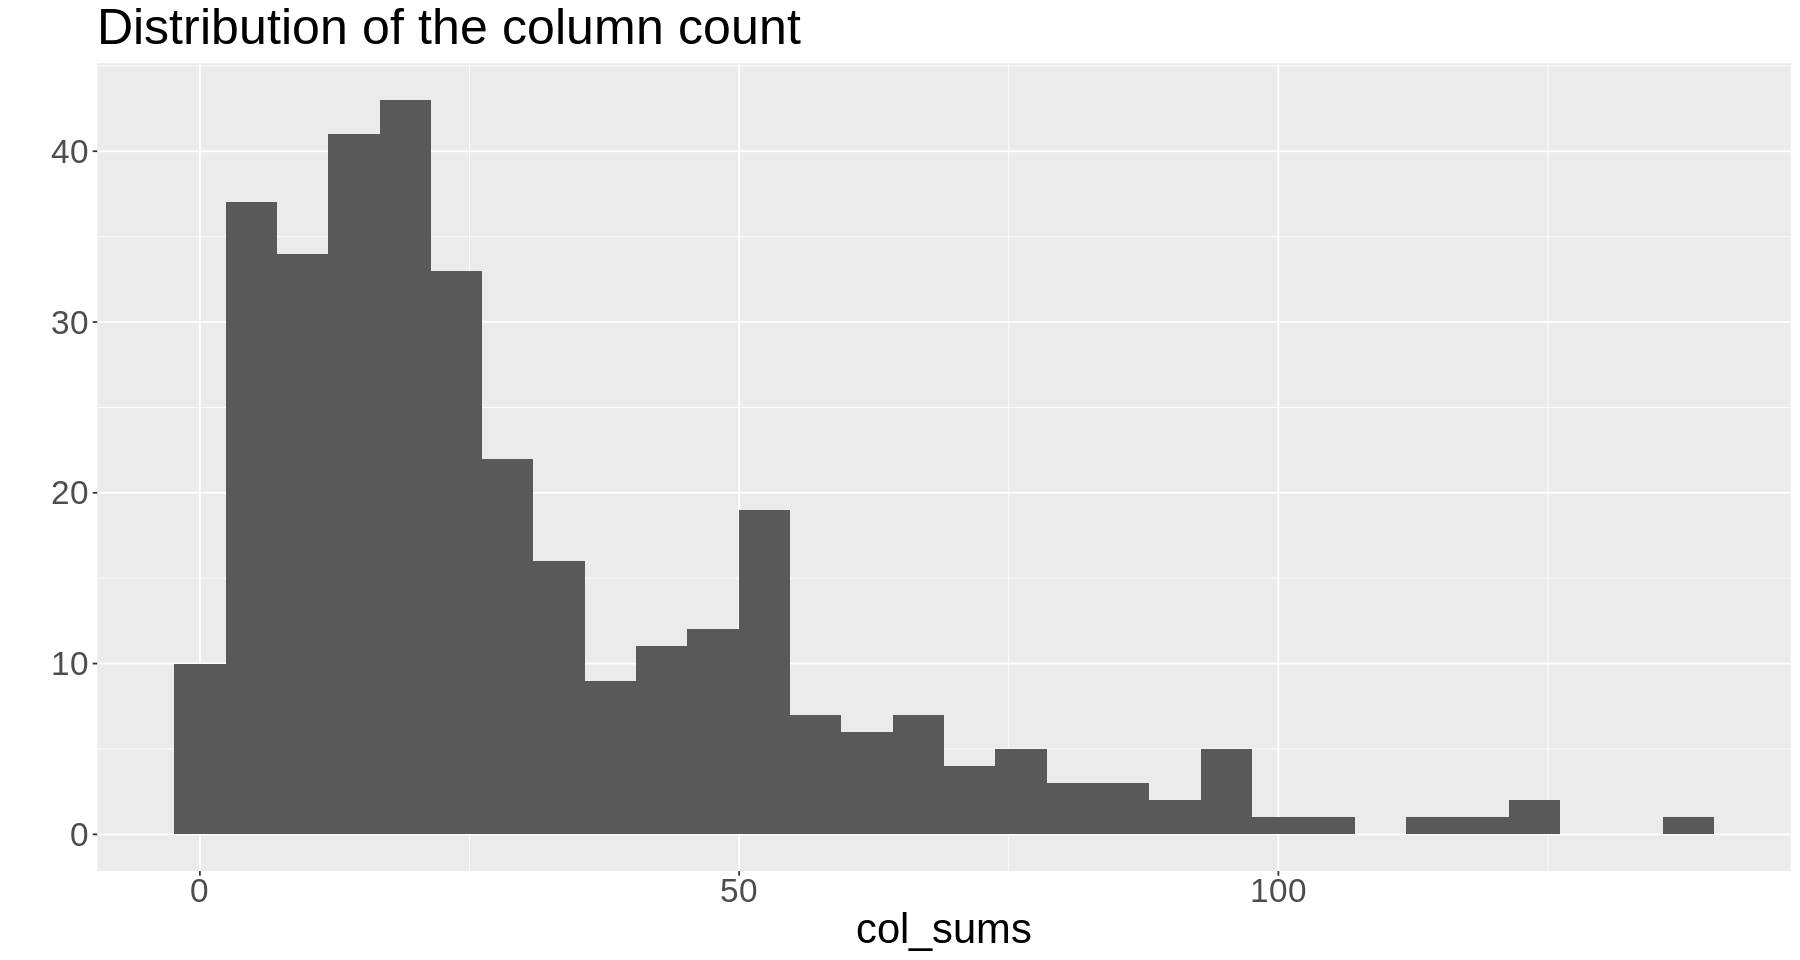

In [38]:
col_sums <- colSums(model_details$sim > 0)
qplot(col_sums) + 
ggtitle("Distribution of the column count")+theme(text = element_text(size = 25), legend.position = "right")  

In [39]:
which_max <- order(col_sums, decreasing = TRUE)[1:6]
rownames(model_details$sim)[which_max]

[1] "I Know What You Did Last Summer (1997)"
[2] "Jungle2Jungle (1997)"                  
[3] "Mimic (1997)"                          
[4] "Close Shave, A (1995)"                 
[5] "Wrong Trousers, The (1993)"            
[6] "Spawn (1997)"

In [40]:
rownames(model_details$sim)[which_max]

[1] "I Know What You Did Last Summer (1997)"
[2] "Jungle2Jungle (1997)"                  
[3] "Mimic (1997)"                          
[4] "Close Shave, A (1995)"                 
[5] "Wrong Trousers, The (1993)"            
[6] "Spawn (1997)"

Now, we are able to recommend movies to the users in the test set. We will define n_recommended that specifies the number of items to recommend to each user. This section will show you the most popular approach to computing a weighted sum:

- ``` n_recommended <- 6```

For each user, the algorithm extracts its rated movies. For each movie, it identifies all its similar items, starting from the similarity matrix. Then, the algorithm ranks each
similar item in this way:
- Extract the user rating associated with this item. The rating is used as a weight.
- Extract the similarity of the item with each rating associated with this item.
- Multiply each weight with the related similarity.
- Sum everything up.

Then, the algorithm identifies the top n recommendations:


```
recc_predicted <- predict(object = recc_model, newdata = recc_data_test, n = n_recommended)
recc_predicted
```

In [41]:
n_recommended  <- 6
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)
recc_predicted

Recommendations as ‘topNList’ with n = 6 for 109 users. 

The recc_predicted object contains the recommendations. Let's take a look at its structure:

```
class(recc_predicted)
## [1] "topNList"
## attr(,"package")
## [1] "recommenderlab"
slotNames(recc_predicted)
## [1] "items" "itemLabels" "n"
```

The slots are:
- items: This is the list with the indices of the recommended items for each user
- itemLabels: This is the name of the items
- n: This is the number of recommendations

In [42]:
recc_predicted@items[[1]]

[1]  27 179 277  68 298 135

In [43]:
recc_user_1 <- recc_predicted@items[[1]]
movies_user_1 <- recc_predicted@itemLabels[recc_user_1]
movies_user_1

[1] "Pulp Fiction (1994)"              "Time to Kill, A (1996)"          
[3] "Ben-Hur (1959)"                   "Phenomenon (1996)"               
[5] "Manchurian Candidate, The (1962)" "Cape Fear (1991)"

In [44]:
df <- data.frame(recc_user_1,movies_user_1)
names(df) <- c("item_idx","item_label")
df

item_idx,item_label
<int>,<chr>
27,Pulp Fiction (1994)
179,"Time to Kill, A (1996)"
277,Ben-Hur (1959)
68,Phenomenon (1996)
298,"Manchurian Candidate, The (1962)"
135,Cape Fear (1991)


In [45]:
recc_matrix <- sapply(recc_predicted@items, function(x){
colnames(ratings_movies)[x]
})
recc_matrix [ ,1:10]

5,6,10,13,21,25,26,38,52,54
Pulp Fiction (1994),Rear Window (1954),Stargate (1994),"Frighteners, The (1996)","Firm, The (1993)",Hoop Dreams (1994),"Lion King, The (1994)",Twelve Monkeys (1995),"Net, The (1995)","Truth About Cats & Dogs, The (1996)"
"Time to Kill, A (1996)","Devil's Advocate, The (1997)",Mrs. Doubtfire (1993),"Firm, The (1993)","Devil's Advocate, The (1997)","Fish Called Wanda, A (1988)","Close Shave, A (1995)",Seven (Se7en) (1995),Natural Born Killers (1994),"Blues Brothers, The (1980)"
Ben-Hur (1959),Broken Arrow (1996),"Godfather: Part II, The (1974)",Tin Cup (1996),Tin Cup (1996),Cinema Paradiso (1988),"Craft, The (1996)",Crimson Tide (1995),Outbreak (1995),Grosse Pointe Blank (1997)
Phenomenon (1996),G.I. Jane (1997),Swingers (1996),Con Air (1997),Beauty and the Beast (1991),Sling Blade (1996),"Abyss, The (1989)","Net, The (1995)",While You Were Sleeping (1995),"Hunchback of Notre Dame, The (1996)"
"Manchurian Candidate, The (1962)",Starship Troopers (1997),Mr. Smith Goes to Washington (1939),Crash (1996),Jerry Maguire (1996),Leaving Las Vegas (1995),Sneakers (1992),Reservoir Dogs (1992),Ace Ventura: Pet Detective (1994),I Know What You Did Last Summer (1997)
Cape Fear (1991),Pretty Woman (1990),Die Hard: With a Vengeance (1995),"Time to Kill, A (1996)",Welcome to the Dollhouse (1995),Harold and Maude (1971),Ace Ventura: Pet Detective (1994),Platoon (1986),"Mask, The (1994)",Speed (1994)


### Exercise 6 (0.5 points)

In previous example we got the recommendations using the dataset `recc_data_test` obtaining the top-n recommendation for the first user in the dataset

**What is the id of that user?**

**Answer:**

Taking a look into the matrix shown above, we can clearly see that the first user id is number 5.

The user id is the column name of the matrix.


### Exercise 7 (1.5 points)

Create a recommender system using a neighbourhood size of 35 and providing for each user the top-7 recommendation. 

- Train recommender system (1.0 point)
- Get the top-7 recommendation for first user in `recc_data_test` (0.5 points)

**Answer:**


In [46]:
### Insert your code here
#Recommender system using a neighbourhood of k=35
recc_model_ibcf_new <- Recommender(data = recc_data_train, method = "IBCF", parameter = list(k = 35))

#Creating the predicted model for each user based on the top 7 recommendation
n_recommended_new  <- 7
recc_predicted_new <- predict(object = recc_model_ibcf_new, newdata = recc_data_test, n = n_recommended_new)
recc_predicted_new

#Showing the recomendations based on the recommended model predictor for the first user
recc_matrix_new <- sapply(recc_predicted_new@items, function(x){
colnames(ratings_movies)[x]
})
recc_matrix_new [ ,1]
as.matrix(recc_matrix_new [ ,1])

Recommendations as ‘topNList’ with n = 7 for 109 users. 

[1] "Time to Kill, A (1996)"          "Ben-Hur (1959)"                 
[3] "Army of Darkness (1993)"         "Maverick (1994)"                
[5] "My Best Friend's Wedding (1997)" "Net, The (1995)"                
[7] "Brazil (1985)"

"Time to Kill, A (1996)"
Ben-Hur (1959)
Army of Darkness (1993)
Maverick (1994)
My Best Friend's Wedding (1997)
"Net, The (1995)"
Brazil (1985)


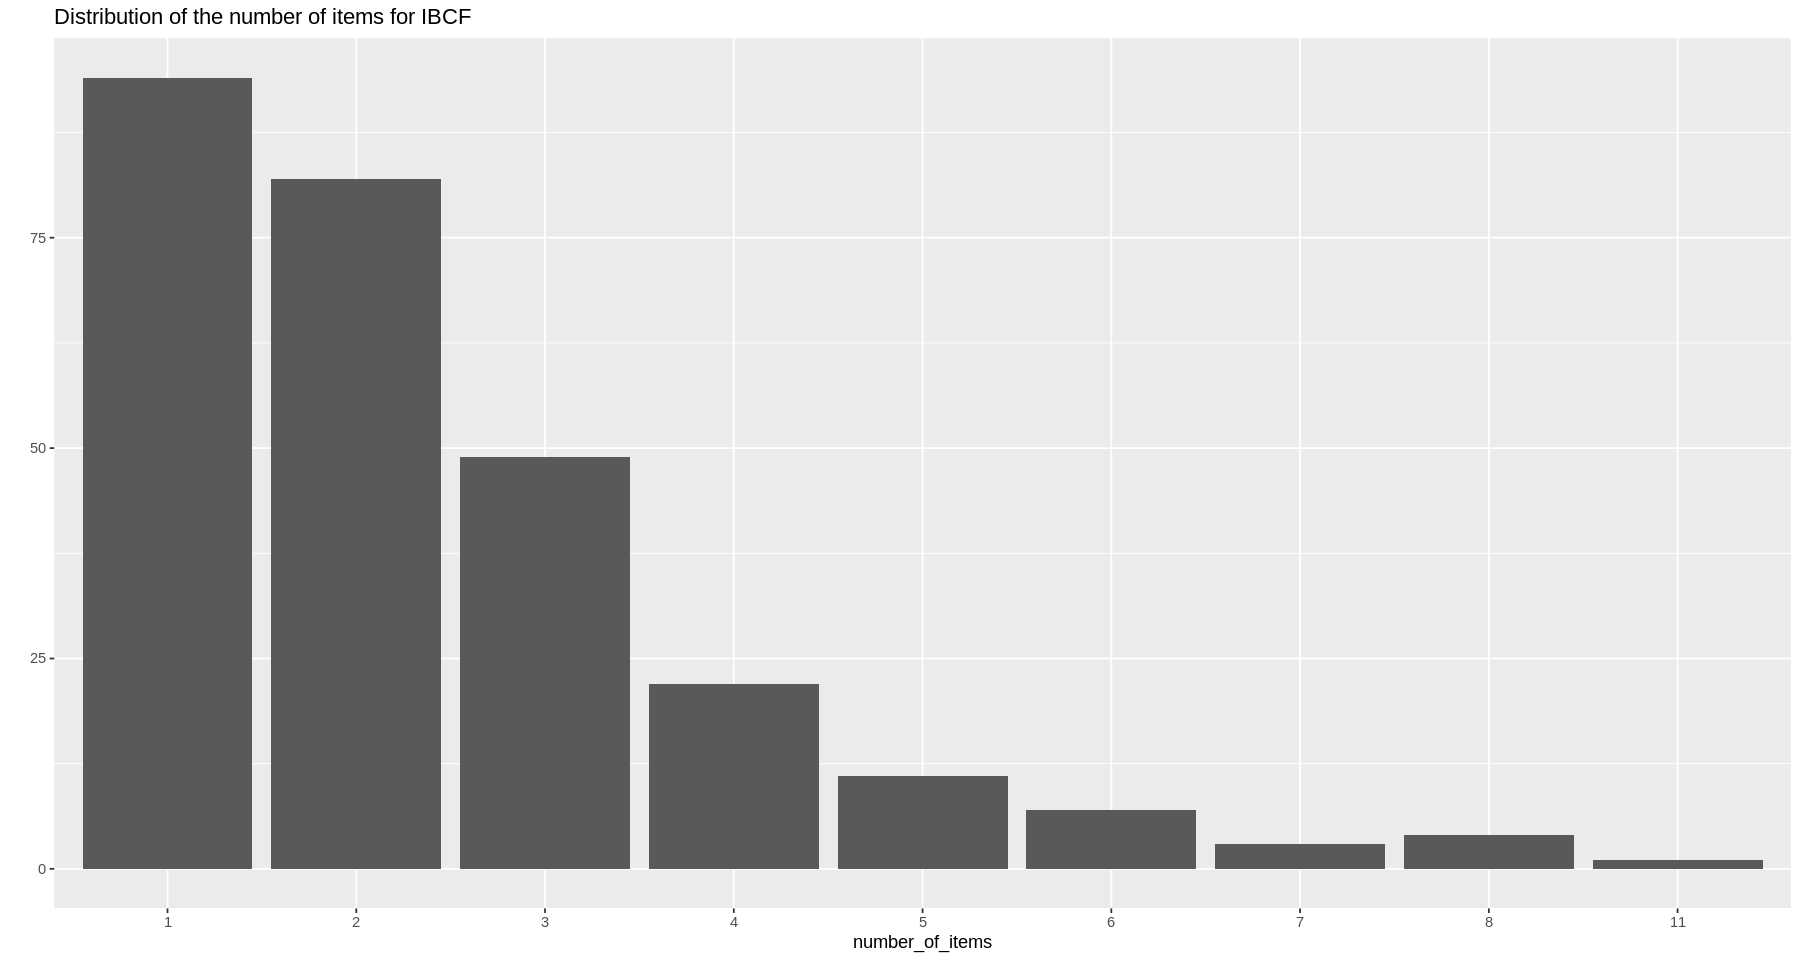

In [47]:
number_of_items <- factor(table(recc_matrix))
chart_title <- "Distribution of the number of items for IBCF"
qplot(number_of_items) + ggtitle(chart_title)

In [48]:
number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 6)
table_top <- data.frame(names(number_of_items_top),
number_of_items_top)
table_top

,names.number_of_items_top.,number_of_items_top
,<chr>,<fct>
Outbreak (1995),Outbreak (1995),11
"Frighteners, The (1996)","Frighteners, The (1996)",8
G.I. Jane (1997),G.I. Jane (1997),8
Natural Born Killers (1994),Natural Born Killers (1994),8
Stargate (1994),Stargate (1994),8
"Craft, The (1996)","Craft, The (1996)",7


## User-based collaborative filtering

The R command to build the model is the same as the previous chapter. Now, the technique is called UBCF:
```
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommender_models$UBCF_realRatingMatrix$parameters
```

Some relevant parameters are:
- method: This shows how to compute the similarity between users
- nn: This shows the number of similar users that are considered in order to calculate the recommendation

In [49]:
recommender_models$UBCF_realRatingMatrix$parameters

$method
[1] "cosine"

$nn
[1] 25

$sample
[1] FALSE

$weighted
[1] TRUE

$normalize
[1] "center"

$min_matching_items
[1] 0

$min_predictive_items
[1] 0

In [50]:
model_details <- getModel(recc_model_ubcf)
model_details

ERROR: ignored

In [51]:
recommenderRegistry$get_entry("UBCF", dataType="realRatingMatrix")

Recommender method: UBCF for realRatingMatrix
Description: Recommender based on user-based collaborative filtering.
Reference: NA
Parameters:
    method nn sample weighted normalize min_matching_items min_predictive_items
1 "cosine" 25  FALSE     TRUE  "center"                  0                    0

## Exercise 8 (1 point)

Modify `recc_model_ubcf` model to use a neighbourhood size of 15.

In [53]:
### insert your code here
recc_model_ubcf <- Recommender(data = recc_data_train, method = "UBCF", parameter = list(nn = 15))


## Exercise 9 (1 point)

Using a similar code like we used for IBCF, make recomendation for the test dataset, **providing 7 recommendations for each user**

```
n_recommended  <- 6
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)
recc_predicted
```

In [54]:
n_recommended  <- 7
recc_predicted_ubcf <- predict(object = recc_model_ubcf, newdata = recc_data_test, n = n_recommended)
recc_predicted_ubcf

#Showing the recomendations based on the recommended model predictor for the first 10 users
recc_matrix_ubcf <- sapply(recc_predicted_ubcf@items, function(x){
colnames(ratings_movies)[x]
})

#as.matrix(recc_matrix_ubcf [ ,1:10])

Recommendations as ‘topNList’ with n = 7 for 109 users. 

## Exercise 10 (1 point)

Based in the previous code show the recommendation for first ten users in test dataset. 

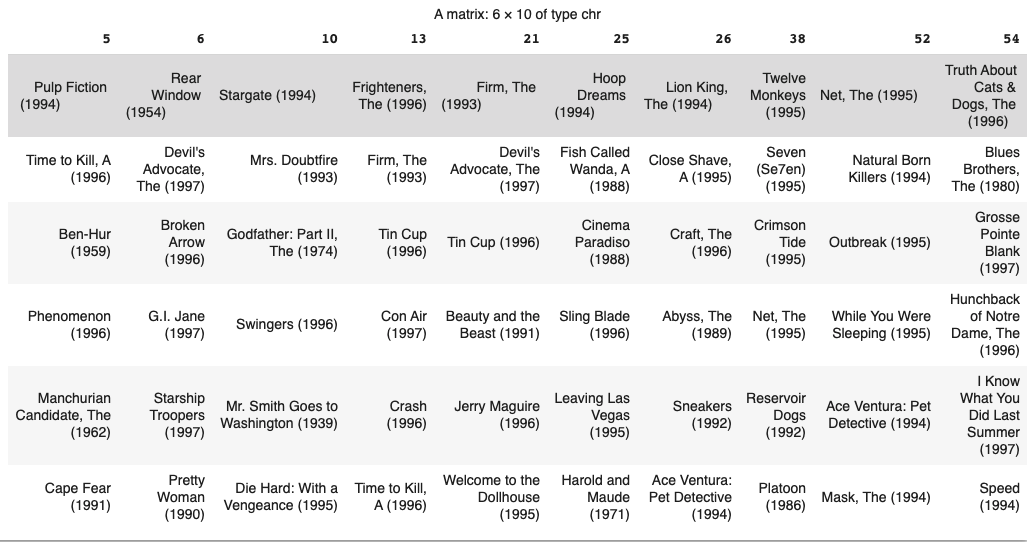


In [55]:
n_recommended  <- 7
recc_predicted_ubcf <- predict(object = recc_model_ubcf, newdata = recc_data_test, n = n_recommended)
recc_predicted_ubcf

#Showing the recomendations based on the recommended model predictor for the first 10 users
recc_matrix_ubcf <- sapply(recc_predicted_ubcf@items, function(x){
colnames(ratings_movies)[x]
})

as.matrix(recc_matrix_ubcf [ ,1:10])

Recommendations as ‘topNList’ with n = 7 for 109 users. 

5,6,10,13,21,25,26,38,52,54
Secrets & Lies (1996),Platoon (1986),Batman (1989),Gone with the Wind (1939),Apt Pupil (1998),Big Night (1996),Schindler's List (1993),Babe (1995),Searching for Bobby Fischer (1993),"Usual Suspects, The (1995)"
Raging Bull (1980),Singin' in the Rain (1952),Star Trek III: The Search for Spock (1984),Raging Bull (1980),As Good As It Gets (1997),Lawrence of Arabia (1962),"Killing Fields, The (1984)","Last of the Mohicans, The (1992)",Henry V (1989),"Nightmare on Elm Street, A (1984)"
Babe (1995),Rumble in the Bronx (1995),Under Siege (1992),"Close Shave, A (1995)",Good Will Hunting (1997),Good Will Hunting (1997),"Edge, The (1997)","Deer Hunter, The (1978)",Harold and Maude (1971),"American President, The (1995)"
"Usual Suspects, The (1995)",Rear Window (1954),Highlander (1986),"Professional, The (1994)","Boot, Das (1981)",Die Hard (1988),Rear Window (1954),"Bridge on the River Kwai, The (1957)",Dragonheart (1996),Secrets & Lies (1996)
Terminator 2: Judgment Day (1991),Arsenic and Old Lace (1944),"Lion King, The (1994)","Killing Fields, The (1984)",Little Women (1994),"Empire Strikes Back, The (1980)",Young Frankenstein (1974),"Philadelphia Story, The (1940)",Vertigo (1958),Wag the Dog (1997)
Apocalypse Now (1979),Amistad (1997),Kolya (1996),Unforgiven (1992),Big Night (1996),Groundhog Day (1993),Platoon (1986),"Maltese Falcon, The (1941)",Face/Off (1997),"Birds, The (1963)"
"Graduate, The (1967)",Die Hard (1988),"Boot, Das (1981)",Citizen Kane (1941),Fly Away Home (1996),Indiana Jones and the Last Crusade (1989),"Wrong Trousers, The (1993)","Manchurian Candidate, The (1962)",While You Were Sleeping (1995),Carrie (1976)


# Bonus track

Use `evaluationScheme` method to evaluate both recommenders created during this lab. Please check the documentation and explain the parameters. 

**Answer:**

The parameters for the `evaluationScheme` are the following:


*   data: data set as a ratingMatrix (the orginal dataset, not our predictions)
*   method: a character string defining the evaluation method to use (so we didn't exactly put the models we've train earlier to test, instead we specified their characteristics)
*   k: number of folds/times to run the evaluation (defaults to 10 for cross-validation and bootstrap and 1 for split).
*   given: single number of items given for evaluation or a vector of length of data giving the number of items given for each observation. 
*   goodRating: numeric; threshold at which ratings are considered good for evaluation





In [56]:
eval_sets <- evaluationScheme(data = ratings_movies,
                              method = "cross-validation",
                              k = 10,
                              given = 7,
                              goodRating = 0)
                        
models_to_evaluate <- list(
  `IBCF Cosine` = list(name = "IBCF", 
                        param = list(method = "cosine")),
  `UBCF Cosine` = list(name = "UBCF",
                        param = list(method = "cosine"))
)
n_recommendations <- c(1, 5, seq(10, 100, 10))

list_results <- evaluate(x = eval_sets, 
                         method = models_to_evaluate, 
                         n = n_recommendations)

IBCF run fold/sample [model time/prediction time]
	 1  [0.223sec/0.024sec] 
	 2  [0.438sec/0.017sec] 
	 3  [0.211sec/0.017sec] 
	 4  [0.214sec/0.018sec] 
	 5  [0.213sec/0.017sec] 
	 6  [0.221sec/0.017sec] 
	 7  [0.224sec/0.017sec] 
	 8  [0.221sec/0.017sec] 
	 9  [0.221sec/0.022sec] 
	 10  [0.216sec/0.017sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.005sec/0.132sec] 
	 2  [0.005sec/0.136sec] 
	 3  [0.015sec/0.129sec] 
	 4  [0.005sec/0.119sec] 
	 5  [0.005sec/0.128sec] 
	 6  [0.005sec/0.129sec] 
	 7  [0.005sec/0.138sec] 
	 8  [0.005sec/0.13sec] 
	 9  [0.005sec/0.131sec] 
	 10  [0.005sec/0.13sec] 


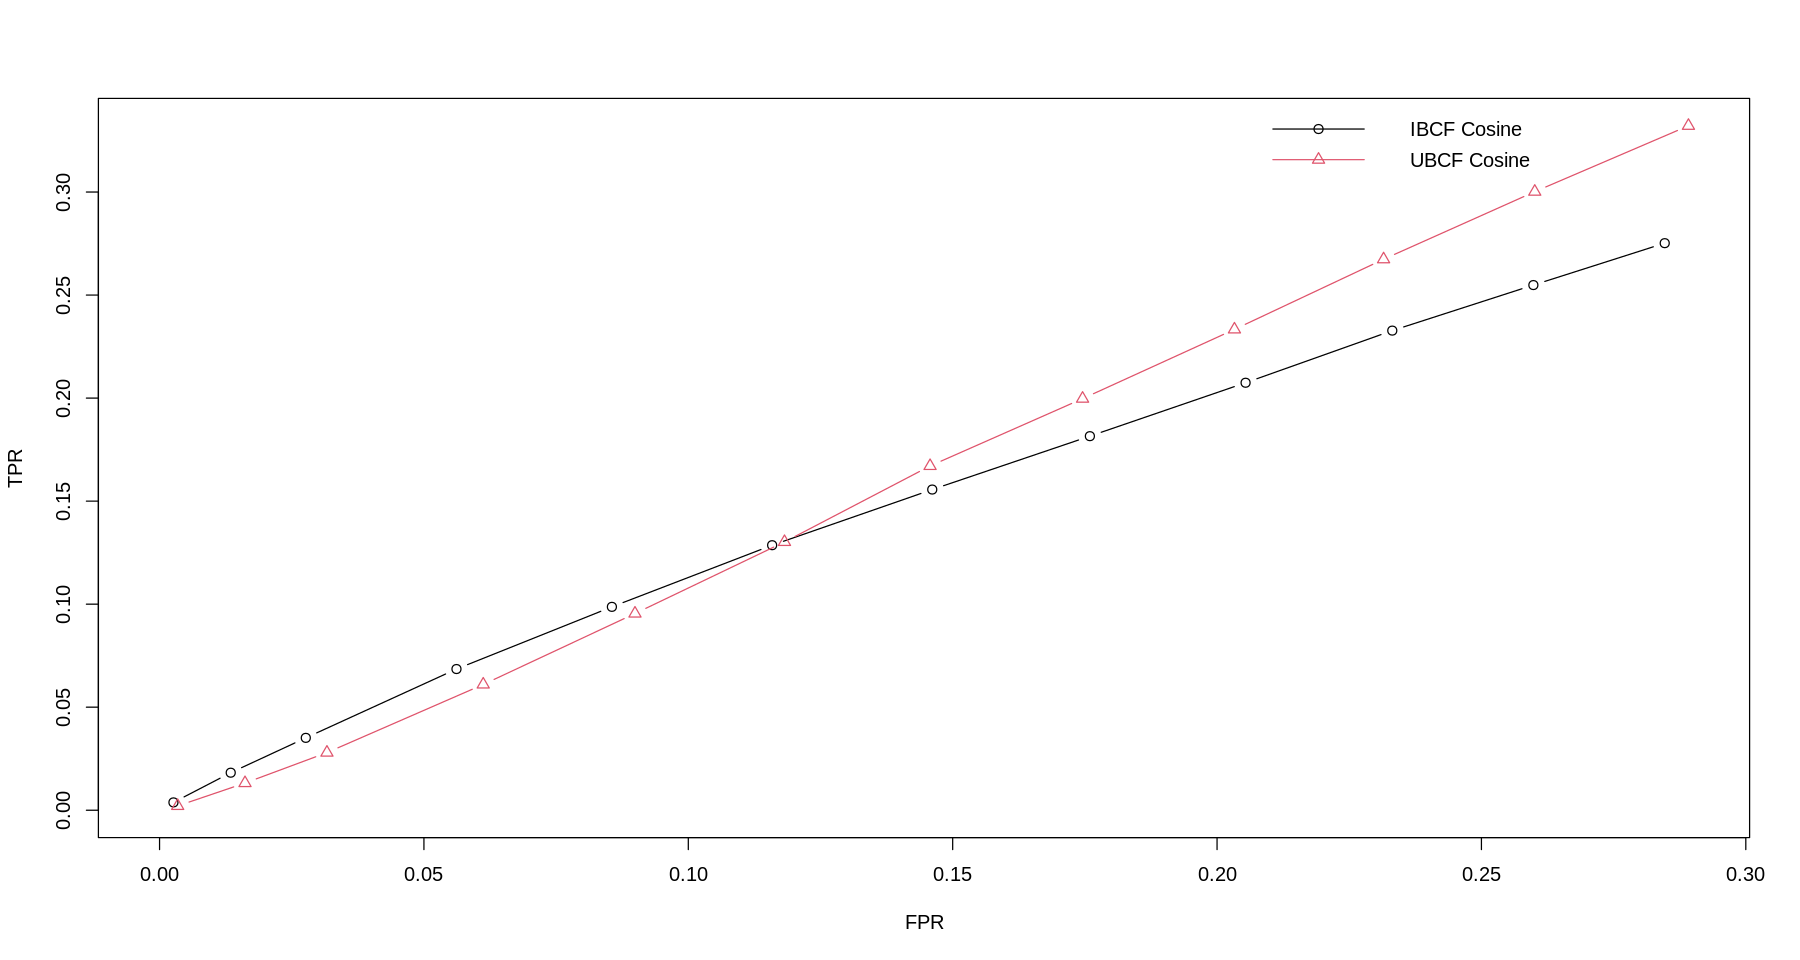

In [57]:
plot(list_results, legend="topright")